In [7]:
!pip install networkx matplotlib scikit-learn pandas numpy > /dev/null


In [8]:
import os
import math
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



In [9]:
def euclidean(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

In [10]:
def build_example_graph():
    """Cria grafo fictício de bairros"""
    G = nx.Graph()
    nodes = {
        "Centro": (-23.5505, -46.6333),
        "Bairro A": (-23.5450, -46.6350),
        "Bairro B": (-23.5520, -46.6400),
        "Bairro C": (-23.5580, -46.6300),
        "Bairro D": (-23.5465, -46.6250),
        "Bairro E": (-23.5620, -46.6380),
        "Bairro F": (-23.5480, -46.6420),
        "Bairro G": (-23.5555, -46.6200)
    }
    for name, (lat, lon) in nodes.items():
        G.add_node(name, x=lon, y=lat)

    def approx_meters(a_lat, a_lon, b_lat, b_lon):
        avg_lat = math.radians((a_lat + b_lat) / 2.0)
        dy = (a_lat - b_lat) * 111000.0
        dx = (a_lon - b_lon) * 111000.0 * math.cos(avg_lat)
        return math.hypot(dx, dy)

    edges = [
        ("Centro", "Bairro A"),
        ("Centro", "Bairro B"),
        ("Centro", "Bairro C"),
        ("Bairro A", "Bairro D"),
        ("Bairro A", "Bairro B"),
        ("Bairro B", "Bairro F"),
        ("Bairro C", "Bairro G"),
        ("Bairro D", "Bairro E"),
        ("Bairro E", "Bairro G"),
        ("Bairro F", "Bairro B"),
        ("Bairro G", "Bairro C")
    ]
    for u, v in edges:
        lat_u, lon_u = G.nodes[u]['y'], G.nodes[u]['x']
        lat_v, lon_v = G.nodes[v]['y'], G.nodes[v]['x']
        dist = approx_meters(lat_u, lon_u, lat_v, lon_v)
        G.add_edge(u, v, weight=dist)
    return G

In [11]:
def generate_fake_deliveries(G, n=20, seed=42):
    """Cria 20 entregas fictícias"""
    random.seed(seed)
    np.random.seed(seed)
    node_names = list(G.nodes)
    node_coords = {n: (G.nodes[n]['y'], G.nodes[n]['x']) for n in node_names}

    orders = []
    for i in range(n):
        base = random.choice(node_names)
        lat0, lon0 = node_coords[base]
        lat = lat0 + np.random.normal(scale=0.003)
        lon = lon0 + np.random.normal(scale=0.003)
        orders.append({"order_id": f"O{i+1:03d}", "lat": lat, "lon": lon})
    return pd.DataFrame(orders)

In [12]:
def run_kmeans(df_orders, k=3):
    coords = df_orders[['lat', 'lon']].to_numpy()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(coords)
    df = df_orders.copy()
    df['cluster'] = labels
    return df, kmeans.cluster_centers_



In [13]:
def associate_orders_to_nodes(G, df_orders):
    nodes = list(G.nodes)
    node_coords = {n: (G.nodes[n]['y'], G.nodes[n]['x']) for n in nodes}
    nearest = []
    for _, row in df_orders.iterrows():
        lat, lon = row['lat'], row['lon']
        best = min(nodes, key=lambda n: euclidean((lat, lon), node_coords[n]))
        nearest.append(best)
    df = df_orders.copy()
    df['nearest_node'] = nearest
    return df


In [15]:
def astar_heuristic(u, v, G):
    ux, uy = G.nodes[u]['x'], G.nodes[u]['y']
    vx, vy = G.nodes[v]['x'], G.nodes[v]['y']
    avg_lat = math.radians((uy + vy) / 2.0)
    dy = (uy - vy) * 111000.0
    dx = (ux - vx) * 111000.0 * math.cos(avg_lat)
    return math.hypot(dx, dy)

In [17]:
def build_routes(G, df_clustered, depot_node="Centro", speed_kmh=30.0):
    clusters = sorted(df_clustered['cluster'].unique())
    all_routes, metrics = {}, []
    for c in clusters:
        sub = df_clustered[df_clustered['cluster'] == c]
        nodes = list(sub['nearest_node'].unique())
        if not nodes: continue
        current = depot_node
        route_nodes = [current]
        total_distance = 0.0
        remaining = set(nodes)
        while remaining:
            candidates = []
            for cand in remaining:
                try:
                    length = nx.shortest_path_length(G, current, cand, weight='weight')
                except nx.NetworkXNoPath:
                    length = float('inf')
                candidates.append((cand, length))
            cand, length = min(candidates, key=lambda t: t[1])
            try:
                path = nx.astar_path(G, current, cand, heuristic=lambda a,b: astar_heuristic(a,b,G), weight='weight')
                route_nodes.extend(path[1:])
                total_distance += length
            except nx.NetworkXNoPath:
                remaining.remove(cand)
                continue
            current = cand
            remaining.remove(cand)
        try:
            back_len = nx.shortest_path_length(G, current, depot_node, weight='weight')
            route_nodes.extend(nx.shortest_path(G, current, depot_node, weight='weight')[1:])
            total_distance += back_len
        except nx.NetworkXNoPath:
            pass
        avg_speed_m_per_min = (speed_kmh * 1000) / 60.0
        total_time_min = total_distance / avg_speed_m_per_min
        all_routes[c] = route_nodes
        metrics.append({
            'cluster': int(c),
            'n_orders': len(sub),
            'total_distance_m': total_distance,
            'total_time_min': total_time_min
        })
    return all_routes, pd.DataFrame(metrics)


In [18]:
def plot_grafo(G):
    pos = {n:(G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700)
    edge_labels = {(u,v): f"{G[u][v]['weight']:.0f}m" for u,v in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Grafo - Malha de Bairros")
    plt.show()


In [19]:
def plot_clusters(G, df, centers):
    pos = {n:(G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, node_color='lightgray', with_labels=True)
    cmap = plt.get_cmap('tab10')
    for c in sorted(df['cluster'].unique()):
        sub = df[df['cluster']==c]
        plt.scatter(sub['lon'], sub['lat'], s=40, color=cmap(c), label=f'Cluster {c}')
    for i,(lat,lon) in enumerate(centers):
        plt.scatter(lon, lat, marker='X', s=100, c='black')
        plt.text(lon, lat, f'C{i}', fontsize=9, va='bottom')
    plt.legend()
    plt.title("Clusters de Entregas (K-Means)")
    plt.show()

In [20]:
def plot_routes(G, all_routes):
    pos = {n:(G.nodes[n]['x'], G.nodes[n]['y']) for n in G.nodes}
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, node_color='lightgray', with_labels=True)
    cmap = plt.get_cmap('tab10')
    for idx,(c,route) in enumerate(all_routes.items()):
        edges = list(zip(route[:-1], route[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=2.5, edge_color=[cmap(idx)])
    plt.title("Rotas Otimizadas por Cluster")
    plt.show()

In [21]:
G = build_example_graph()
df_orders = generate_fake_deliveries(G)
df_clustered, centers = run_kmeans(df_orders, k=3)
df_assoc = associate_orders_to_nodes(G, df_clustered)
all_routes, metrics = build_routes(G, df_assoc)


In [22]:
print("📊 Métricas por cluster:")
display(metrics)


📊 Métricas por cluster:


,cluster,n_orders,total_distance_m,total_time_min
0,0,10,3241.916090,6.483832
1,1,5,5126.631741,10.253263
2,2,5,1795.332727,3.590665



📍 Grafo da malha urbana:


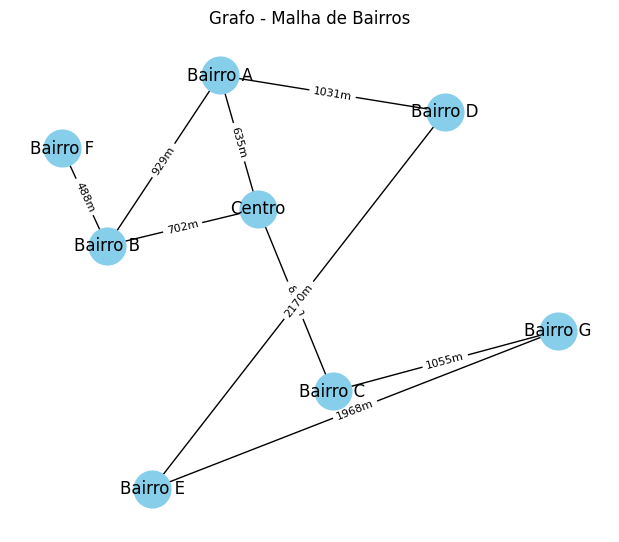

In [23]:

print("\n📍 Grafo da malha urbana:")
plot_grafo(G)

📦 Clusters de entregas:


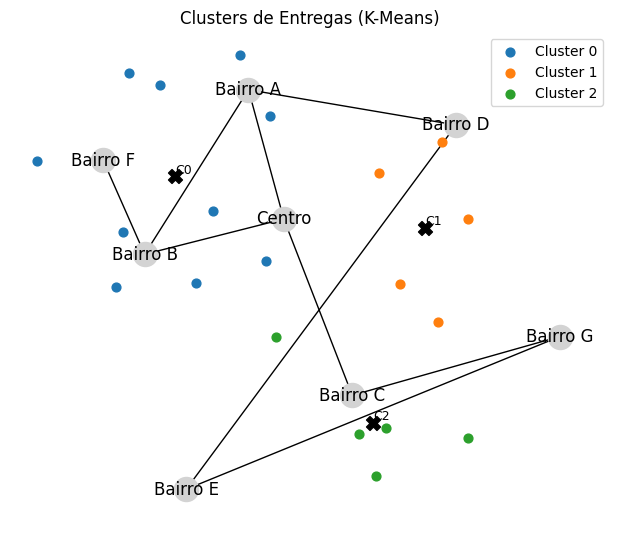

In [24]:
print("📦 Clusters de entregas:")
plot_clusters(G, df_assoc, centers)

🚚 Rotas otimizadas:


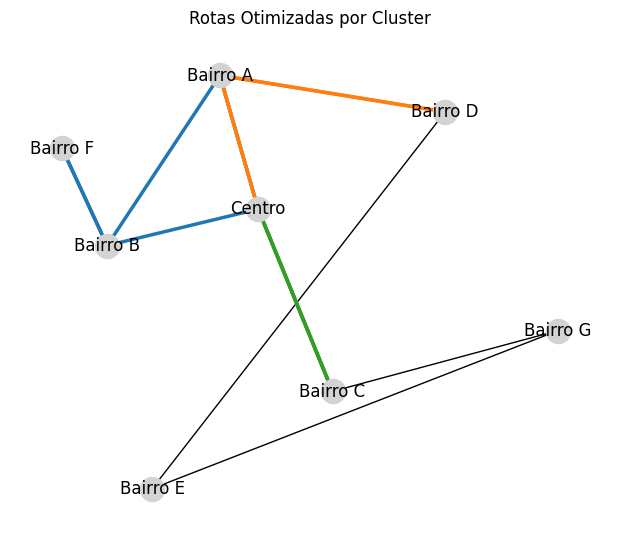

In [25]:
print("🚚 Rotas otimizadas:")
plot_routes(G, all_routes)